In [25]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY']=userdata.get('OPEN_AI_KEY')

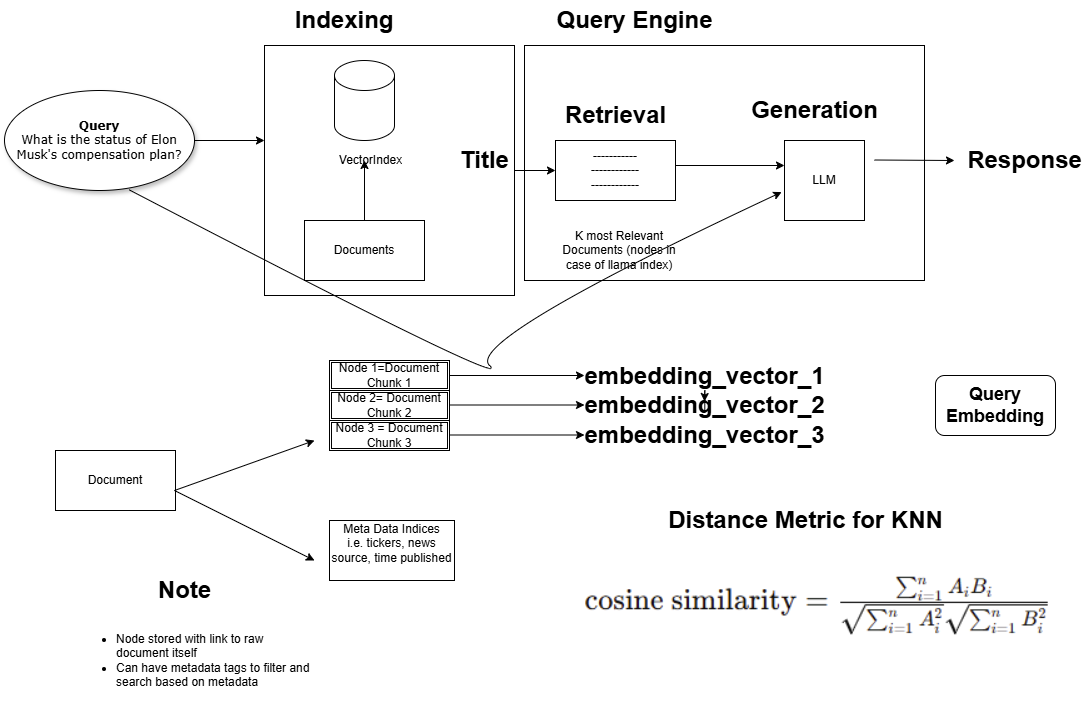

In [3]:
!pip install llama_index

In [31]:
from google.colab import userdata
import os

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = userdata.get('langchain_api')
os.environ['GROQ_API_KEY'] = userdata.get('groq_api')

In [8]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/adidror005/youtube-videos/main/small_news_dataset%20(1).csv")

df.head()

,author,content,created_at,headline,id,images,source,summary,symbols,updated_at,url
0,Anan Ashraf,<p><strong>Future Fund&nbsp;</strong>Managing ...,2024-05-18T08:03:56Z,Tesla Bull Gary Black Says 'Likely' Approval O...,38907041,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Gary Black predicts shareholders will likely a...,['TSLA'],2024-05-18T08:04:55Z,https://www.benzinga.com/news/24/05/38907041/t...
1,Anusuya Lahiri,"<p>This past week, eight companies in&nbsp;<st...",2024-05-06T18:59:43Z,"Thanks To Apple, This Analyst Is Optimistic On...",38651469,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Key Insights from KeyBanc: Semiconductor Secto...,"['AAPL', 'AMD', 'ARM', 'ARW', 'AVT', 'CRUS', '...",2024-05-06T18:59:43Z,https://www.benzinga.com/analyst-ratings/analy...
2,Benzinga Neuro,"<p><strong>Ross Gerber</strong>, the CEO of <s...",2024-04-18T05:21:01Z,Tesla Board's Credibility At Stake With $56B E...,38306906,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,"Gerber, in an interview stated, &#34;I&#39;m s...",['TSLA'],2024-04-18T05:21:02Z,https://www.benzinga.com/markets/equities/24/0...
3,Vaishali Prayag,"<p><strong>Recursion Pharmaceuticals, Inc.</st...",2024-05-13T20:51:35Z,Recursion Pharmaceuticals Stock Surges 10% As ...,38802247,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,"Recursion Pharmaceuticals, Inc. (NASDAQ: RXRX)...","['NVDA', 'RXRX']",2024-05-13T20:51:36Z,https://www.benzinga.com/news/24/05/38802247/r...
4,Anusuya Lahiri,<p><strong>Nvidia Corp</strong> (NASDAQ:<a cla...,2024-04-22T12:44:44Z,Nvidia Joins Forces with Japan's Tech Institut...,38355877,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Nvidia partners with Japan&#39;s National Inst...,"['AMZN', 'MSFT', 'NVDA', 'TSM']",2024-04-22T12:44:44Z,https://www.benzinga.com/government/24/04/3835...


In [9]:
from IPython.display import HTML

HTML(df.content.iloc[0])

## Loading stage (Get your data)
* There are also advanced connectors like or readors like SimpleDirectoryReador, SlackReader,DiscordReader and many many more https://docs.llamaindex.ai/en/stable/module_guides/loading/connector/ BUT we will do basic.
* We will do it from scratch without connectors in this example.
  - We add metadata since later we want to maybe search based on metadata filters also
  - Document(text=text,metadata=dictionary_of_meta_data)

In [11]:
from llama_index.core import Document, VectorStoreIndex

documents=[]

for index, row in df.iterrows():
  # print(index)
  # print(row)
  text = row.content
  row_dict = row.to_dict()
  meta_data_dict = {k:v for k,v in row_dict.items() if k in ['created_at','author']}
  documents.append(Document(text=text,metadata=meta_data_dict))

0
author                                              Anan Ashraf
content       <p><strong>Future Fund&nbsp;</strong>Managing ...
created_at                                 2024-05-18T08:03:56Z
headline      Tesla Bull Gary Black Says 'Likely' Approval O...
id                                                     38907041
images        [{'size': 'large', 'url': 'https://cdn.benzing...
source                                                 benzinga
summary       Gary Black predicts shareholders will likely a...
symbols                                                ['TSLA']
updated_at                                 2024-05-18T08:04:55Z
url           https://www.benzinga.com/news/24/05/38907041/t...
Name: 0, dtype: object
1
author                                           Anusuya Lahiri
content       <p>This past week, eight companies in&nbsp;<st...
created_at                                 2024-05-06T18:59:43Z
headline      Thanks To Apple, This Analyst Is Optimistic On...
id           

In [12]:
documents[:3]

[Document(id_='04153350-f5f4-480a-82c8-bf435af05569', embedding=None, metadata={'author': 'Anan Ashraf', 'created_at': '2024-05-18T08:03:56Z'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='<p><strong>Future Fund&nbsp;</strong>Managing Partner&nbsp;<strong>Gary Black</strong> believes <strong>Tesla Inc</strong> (NASDAQ:<a class="ticker" href="https://www.benzinga.com/stock/TSLA#NASDAQ">TSLA</a>) CEO <strong>Elon Musk</strong>&#8216;s 2018 compensation package will likely be overwhelmingly <a href="https://www.benzinga.com/news/24/04/38288360/breaking-tesla-shareholders-to-vote-again-on-ceo-elon-musks-voided-47b-pay-package">approved by shareholders</a> in the upcoming annual meeting, rendering a &#8220;huge positive&#8221; to the company.</p>\n\n\n\n<p><strong>What Happened:</strong> Black is of the opinion that the annual shareholder meeting expected to be held on June 13, 2024, at 3:30 p.m. Central Time (CT) will be the next &#8220;major cata

### Split document into nodes

In [13]:
from llama_index.core.node_parser import SentenceSplitter

text_splitter = SentenceSplitter(chunk_size= 512, chunk_overlap=64)
nodes= text_splitter.get_nodes_from_documents(documents)
len(nodes)

34

In [37]:
nodes[0]

TextNode(id_='99843414-bcbd-4bf3-82e7-138db2b62adf', embedding=None, metadata={'author': 'Anan Ashraf', 'created_at': '2024-05-18T08:03:56Z'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='04153350-f5f4-480a-82c8-bf435af05569', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'author': 'Anan Ashraf', 'created_at': '2024-05-18T08:03:56Z'}, hash='5806882f7748857ada563c97154bc87c2ef0f99cd3ebf19638e31c9875e2fe64'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='ef3725dd-033f-4532-9164-f9db1266a782', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='01fd26050a947204eaf09345c66da41a38ad883e333f1021d910a8c6b2ca519c')}, text='<p><strong>Future Fund&nbsp;</strong>Managing Partner&nbsp;<strong>Gary Black</strong> believes <strong>Tesla Inc</strong> (NASDAQ:<a class="ticker" href="https://www.benzinga.com/stock/TSLA#NASDAQ">TSLA</a>) CEO <strong>Elon Musk</strong>&#8216;s 2018 compensation package 

In [38]:
# Define a custom Document class that includes a 'page_content' attribute
class DocumentForChroma:
    def __init__(self, page_content, metadata=None):
        self.page_content = page_content
        self.metadata = metadata if metadata else {}

# Convert TextNode objects to Document objects
docs_for_chroma = []

for node in nodes:
    doc = DocumentForChroma(
        page_content=node.text,  # Use the text content from the TextNode
        metadata=node.metadata   # Retain metadata from the TextNode
    )
    docs_for_chroma.append(doc)

# Now, docs_for_chroma contains the converted documents with page_content
docs_for_chroma[0]

## Indexing Stages
* Vector Index based on node embeddings is the most common, but there are of course other indexes like keyword indexes and metadata related indexes for querying.

### Vector Store Index
* Index nodes based on embeddings

In [28]:
!pip install chromadb langchain_community langchainhub langchain langchain-core langchain_google_genai

In [17]:
!pip install sentence-transformers

In [40]:
from llama_index.core import VectorStoreIndex
import chromadb.utils.embedding_functions as embedding_functions
from langchain.embeddings import HuggingFaceEmbeddings
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Initialize the Hugging Face Sentence Transformer model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Creating a vector store
vectorstore = Chroma.from_documents(
    documents=docs_for_chroma,
    embedding=embeddings
)

In [43]:
# Get all document IDs
document_ids = vectorstore.get()["ids"]

print("Document IDs:", document_ids)

Document IDs: ['12cef1a7-b7ca-46cc-a0c9-77e3eeaac34d', '2f0c9089-d708-45bb-a78e-93bd9cbb5601', '3bedb029-8875-4949-8363-17f93c3a0240', '4499e633-5062-4b7b-84eb-7c0870441e07', '4b150ffd-a7ea-497d-bfb5-29fae849ff88', '53c738c3-184c-4cd1-a73f-ddb88dc6c5d5', '57f00e72-e697-4a6c-9fb2-d4ee548671ce', '601d5674-11c5-42d5-ac7d-66cf44475266', '61e9ca7b-7aa3-4465-a716-a9b1d43acf1d', '6927769b-9141-4011-bbe0-c6b38ccb1f60', '69d9a3cc-5756-4da3-b18a-82b9519fd1c1', '6b36d721-c43c-4a7e-aaa7-7dd0ba046ac7', '74a7f517-09e7-4db4-b531-b6c4169a3122', '77422640-1f5d-44e2-8621-f9bbb6a8a1f9', '7ad96446-c069-44cd-b359-32f935c3bfbd', '7df81a85-8fc5-4694-9a26-419a622d2460', '7fef208b-7e77-40a4-9d0f-aa4ba279a0c7', '8da20059-0d01-447a-9691-d558177adbff', '95b2001b-af6c-4458-a9bb-45896b57a089', '977a70bf-0c4a-440b-9ef3-8f4842a556ca', '981c97b5-374b-454d-a4b9-965e25f73663', '99a30c2c-816a-4aec-a1fe-f7674b154f22', '9ade98e1-d0fe-425b-97e7-ed6e9368d3bb', 'b854ee28-7b5c-4837-b41d-3e3b8f0efd1a', 'b8ee3880-ec3b-4d79-b18a-

In [84]:
retrieved_doc = vectorstore.get(document_ids[0])
retrieved_doc.keys()
# document_text = retrieved_doc.documents
# document_text

dict_keys(['ids', 'embeddings', 'metadatas', 'documents', 'uris', 'data', 'included'])

In [85]:
retrieved_doc

{'ids': ['12cef1a7-b7ca-46cc-a0c9-77e3eeaac34d'],
 'embeddings': None,
 'metadatas': [{'author': 'Vaishali Prayag',
   'created_at': '2024-05-13T20:51:35Z'}],
 'documents': ['<p><strong>Recursion Pharmaceuticals, Inc.</strong> (NASDAQ:<a class="ticker" href="https://www.benzinga.com/stock/RXRX#NASDAQ">RXRX</a>) made waves Monday with the announcement of the completion of its groundbreaking BioHive-2 supercomputer, as well as the <a href="https://www.benzinga.com/pressreleases/24/05/g38782854/recursion-announces-completion-of-nvidia-powered-biohive-2-the-largest-supercomputer-in-pharmaceut">notable surge in its stock that followed.</a></p>\n\n\n\n<p><strong>RXRX Price Action:</strong> Recursion Pharmaceutical shares closed at $9.48 on Monday, reflecting an impressive gain of 10.2% compared to the previous day&#8217;s close, according to<a href="https://pro.benzinga.com/dashboard?new_user=False&amp;backend=google-oauth2"> Benzinga Pro</a>.</p>\n\n\n\n<p><strong>What Happened:</strong> Re

# Now when we perform the similarlity search it return a document which is in Document format but when we get doc through ID then we get the attributes like id, embeddings etc

In [78]:
# Example query (this assumes you have a query that matches one of your documents)
query = "Currently, while Tesla continues to ramp efforts and achievements in the direction of autonomous driving, earnings estimates are low owing to price cuts and falling delivery estimates, he said. Black holds a price target of $200 for Tesla"

# Perform a similarity search to retrieve documents
results = vectorstore.similarity_search(query, k=1)
results
# # Inspect the results
# for result in results:
#     print("Document:", result.page_content)
#     print("Metadata:", result.metadata)


[Document(metadata={'author': 'Anan Ashraf', 'created_at': '2024-05-18T08:03:56Z'}, page_content='<p>Currently, while Tesla continues to ramp efforts and achievements in the direction of autonomous driving, earnings estimates are low owing to price cuts and falling delivery estimates, he said. Black holds a price target of $200 for Tesla.</p>\n\n\n\n<figure class="wp-block-embed is-type-rich is-provider-twitter wp-block-embed-twitter"><div class="wp-block-embed__wrapper">\n<blockquote class="twitter-tweet" data-width="500" data-dnt="true"><p lang="en" dir="ltr"><a href="https://twitter.com/search?q=%24TSLA&amp;src=ctag&amp;ref_src=twsrc%5Etfw">$TSLA</a> on the other hand, continues to make great strides in FSD and autonomous driving, but earnings estimates keep falling because of price cuts and now ironically falling delivery estimates (usually price cuts increase volumes). The next major catalyst is the June 13th annual… <a href="https://t.co/lgTW204Ygz">pic.twitter.com/lgTW204Ygz</a>

## Creating embedding

In [83]:
retrieved_doc.keys()

dict_keys(['ids', 'embeddings', 'metadatas', 'documents', 'uris', 'data', 'included'])

In [91]:
documents = retrieved_doc['documents']
documents=documents[0]

In [92]:
embedding_examples = embeddings.embed_query(documents)
embedding_examples

[-0.07598698884248734,
 -0.09461358189582825,
 -0.004213840700685978,
 -0.012351184152066708,
 -0.005672391504049301,
 -0.019272305071353912,
 -0.03279293328523636,
 0.08200491219758987,
 0.019092436879873276,
 0.015108156017959118,
 -0.0377994067966938,
 0.057218462228775024,
 -0.02119278721511364,
 0.026864850893616676,
 -0.05361348018050194,
 0.026784688234329224,
 0.012165111489593983,
 -0.05933792516589165,
 -0.07445742189884186,
 -0.011736667715013027,
 -0.05563659965991974,
 -0.034979939460754395,
 0.04541536793112755,
 0.020778896287083626,
 0.07257221639156342,
 0.06801524013280869,
 -0.018541894853115082,
 -0.023727627471089363,
 0.011163139715790749,
 -0.03372962027788162,
 0.037340544164180756,
 -0.0071361432783305645,
 -0.02588311769068241,
 -0.044802796095609665,
 -0.007718997076153755,
 0.04917169734835625,
 -0.03064701333642006,
 -0.035293277353048325,
 0.07251930981874466,
 -0.018620815128087997,
 -0.0035274112597107887,
 -0.01168595440685749,
 -0.06462749093770981,
 0

#### Get Query Engine For Retrieval and Synthesis

In [93]:
query_engine = vectorstore.as_query_engine(
    response_mode='tree_summarize',similarity_top_k=3
)

* Query the query engine to get the response

In [ ]:
query = "What are some upcoming dates TSLA investors should keep their eyes on related to Elon Musk's comp plan"
response = query_engine.query(query)

In [ ]:
print(response.response)

Investors should keep an eye on the upcoming annual shareholder meeting scheduled for June 13, 2024, at 3:30 p.m. Central Time (CT) where the vote on the reinstatement of Elon Musk's 2018 compensation package is expected to take place. Additionally, the new vote on Musk's $56 billion pay package is set to occur on May 7.


In [ ]:
query = "What are some upcoming dates TSLA investors should keep their eyes on"
response = query_engine.query(query)

In [ ]:
print(response.response)

Investors in TSLA should keep an eye on the upcoming annual shareholder meeting scheduled for June 13, 2024, at 3:30 p.m. Central Time (CT). This meeting is expected to be a major catalyst for the company's future direction. Additionally, there is a vote set to take place on May 7 regarding the reinstatement of Elon Musk's $56 billion pay package, which could also be significant for TSLA investors.


* Can view the 3 nearest neighbor nodes to the query

In [ ]:
len(response.source_nodes)

3

In [ ]:
response.source_nodes[0]

NodeWithScore(node=TextNode(id_='fc345690-bfc4-45f9-804a-bfe67f8a20ea', embedding=None, metadata={'author': 'Anan Ashraf', 'created_at': '2024-05-18T08:03:56Z'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='20bad3ab-2907-4d2c-9537-bc7a89b2182f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'author': 'Anan Ashraf', 'created_at': '2024-05-18T08:03:56Z'}, hash='5806882f7748857ada563c97154bc87c2ef0f99cd3ebf19638e31c9875e2fe64'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='abc4623f-fdb4-48b5-8fb2-b8b29dc7dca7', node_type=<ObjectType.TEXT: '1'>, metadata={'author': 'Anan Ashraf', 'created_at': '2024-05-18T08:03:56Z'}, hash='0ee9652ca1ee56e2155bfd29c8fcf3e37838ae6efbf10ef977aabd94a35f1aa4'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='ccbe8d07-ad7b-410a-a4e5-52b7a1767b3b', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='e1c31f212f684af62c2f7d443b04d6b1aa78d72f96e1635532

In [ ]:
for i,node in enumerate(response.source_nodes):
  print(f"Node {i}, Similarity Score: {node.score}")
  #print(node.text)



Node 0, Similarity Score: 0.8574934434015743
Node 1, Similarity Score: 0.8457253862201292
Node 2, Similarity Score: 0.8274041283169714


* We can manually see how these similarity scores are computed by
1. Embedding Query
2. Calculating cosine similarity between node embedding and query embedding.

In [ ]:
from llama_index.core import Settings

query_embedding = Settings.embed_model.get_text_embedding(query)

In [ ]:
len(query_embedding)

1536

In [ ]:
retrieved_node_id=response.source_nodes[0].node_id
retrieved_node_id

'fc345690-bfc4-45f9-804a-bfe67f8a20ea'

In [ ]:
retrieved_node_embedding=index.vector_store.data.embedding_dict[retrieved_node_id]
len(retrieved_node_embedding)

1536

* Calculate cosine similarity between retrieved node embedding + query embedding vector

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([query_embedding],[retrieved_node_embedding])

array([[0.85749344]])

### A few notes on customization
* Can set settings.embed_model and settings.llm_model to customize
* Can customize embeding model
* Can customize llm model
* See guide below you can use models on Ollama/Huggingface/many other models.
https://docs.llamaindex.ai/en/stable/module_guides/models/




In [ ]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding


Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")
Settings.llm_model = OpenAI(model="text-davinci-003")


#### Here is an eample of how to use Huggingface embeddings

In [ ]:
!pip install llama-index-embeddings-huggingface
!pip install llama-index-llms-huggingface
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.2/853.2 kB 12.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core import Settings
import torch

Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# setup prompts - specific to StableLM
from llama_index.core import PromptTemplate
from llama_index.llms.huggingface import HuggingFaceLLM


# This will wrap the default prompts that are internal to llama-index
# taken from https://huggingface.co/Writer/camel-5b-hf
query_wrapper_prompt = PromptTemplate(
    "Below is an instruction that describes a task. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\n{query_str}\n\n### Response:"
)

llm = HuggingFaceLLM(
    context_window=2048,
    max_new_tokens=256,
    generate_kwargs={"temperature": 0.25, "do_sample": False},
    query_wrapper_prompt=query_wrapper_prompt,
    tokenizer_name="Writer/camel-5b-hf",
    model_name="Writer/camel-5b-hf",
    device_map="auto", #Need pip install accelerate for this
    tokenizer_kwargs={"max_length": 2048},
    # uncomment this if using CUDA to reduce memory usage
    # model_kwargs={"torch_dtype": torch.float16}
)

Settings.chunk_size = 512
Settings.llm = llm